# 1. Загрузка и подготовка данных

In [81]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
def read_txt(all_text, file_name):
  with open(file_name, 'r') as f:
      text = f.read().lower()

  text = re.sub('[^а-яё ]', ' ', text)
  text = re.sub(' +', ' ', text)
  all_text = ' '.join([all_text, text])

  return all_text

In [83]:
text = ''
text = read_txt(text, 'tom_1.txt')
text = read_txt(text, 'tom_2.txt')
text = read_txt(text, 'tom_3.txt')
text = read_txt(text, 'tom_4.txt')
text = text.lstrip()
text[:100]

'лев толстой война и мир том том часть первая часть орая часть третья том лев николаевич толстой войн'

# 2. Матрица переходных вероятностей

In [84]:
russian_letters = ''.join([chr(i) for i in range(1072, 1078)]) + 'ё' + ''.join([chr(i) for i in range(1078, 1104)]) + ' '
russian_letters

'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '

In [85]:
position = {letter: i for i, letter in enumerate(russian_letters)}

In [86]:
probabilities = np.zeros((len(russian_letters), len(russian_letters)))

for cp, cn in zip(text[:-1], text[1:]):
    probabilities[position[cp], position[cn]] += 1

probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

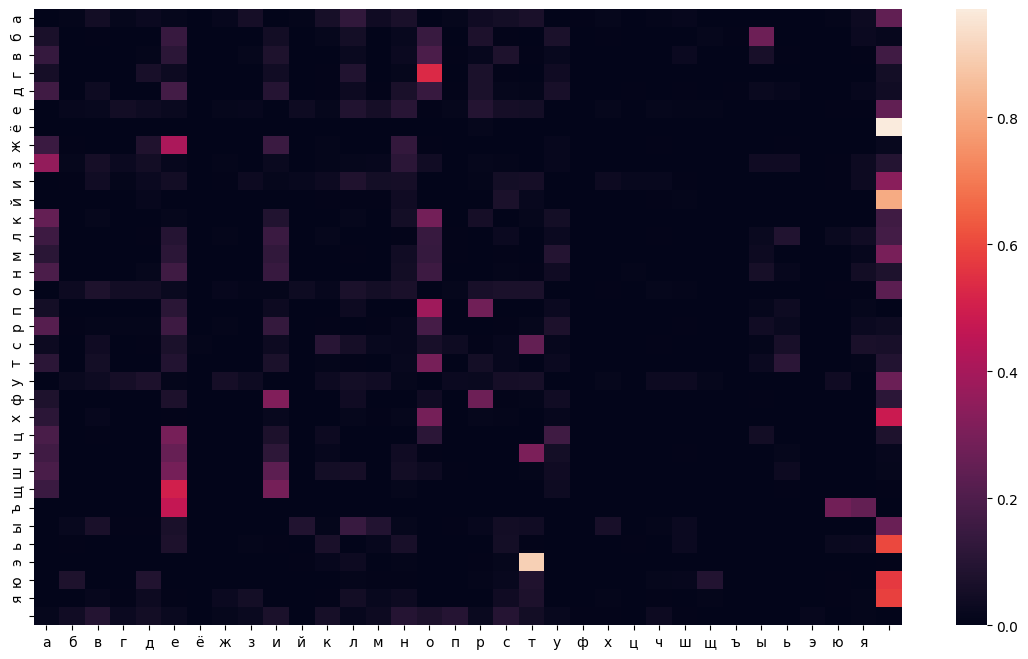

In [87]:
df = pd.DataFrame(probabilities, index=(i for i in russian_letters), columns=(c for c in russian_letters))

plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

# 3. Вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р»

In [162]:
combinations = 0
probability = 0

start = position['п']
end = position['р']
prior = 1. / len(russian_letters)

for c1 in russian_letters:
  for c2 in russian_letters:
    proba = prior * probabilities[start, position[c1]] * probabilities[position[c1], position[c2]] * probabilities[position[c2], end]
    if proba > 0:
      combinations += 1
      probability += proba
print('Количество комбинаций: ', combinations)
print('Вероятность: ', probability)

Количество комбинаций:  561
Вероятность:  0.0009495548591152439


И вариант через возведение матрицы в степень:

In [164]:
df_power = np.linalg.matrix_power(df, 3)
df_power = pd.DataFrame(df_power, index=(i for i in russian_letters), columns=(c for c in russian_letters))
df_power['р']['п'] * prior

0.0009495548591152439

# 4. Генерация слова, начинающегося с буквы «Б», длиной восемь символов с помощью матрицы переходных вероятностей

In [175]:
start = 'б'
length = 7

word = []
word.append(start)

for i in range(length):
    index = position[word[i]]
    next_char = np.random.choice(list(russian_letters), p=probabilities[index])
    word.append(next_char)

print (''.join(word))

багодена


# 5. Оценка ряда через HMM

In [316]:
pip install hmmlearn

In [317]:
from hmmlearn.hmm import GaussianHMM

In [318]:
series = pd.read_csv('mean-monthly-air-temperature-deg.csv')['Deg']
values = series.values.reshape(-1,1)

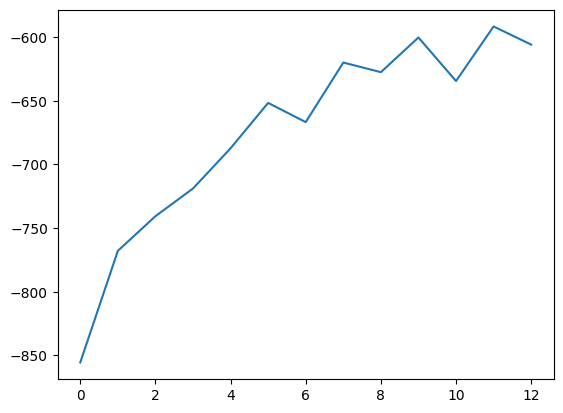

In [319]:
score = []

for n in range(1, 14):
  model = GaussianHMM(n_components=n,
                      covariance_type="diag",
                      n_iter=1000)
  model.fit(values)
  score.append(model.score(values))

plt.plot(score)
plt.show()

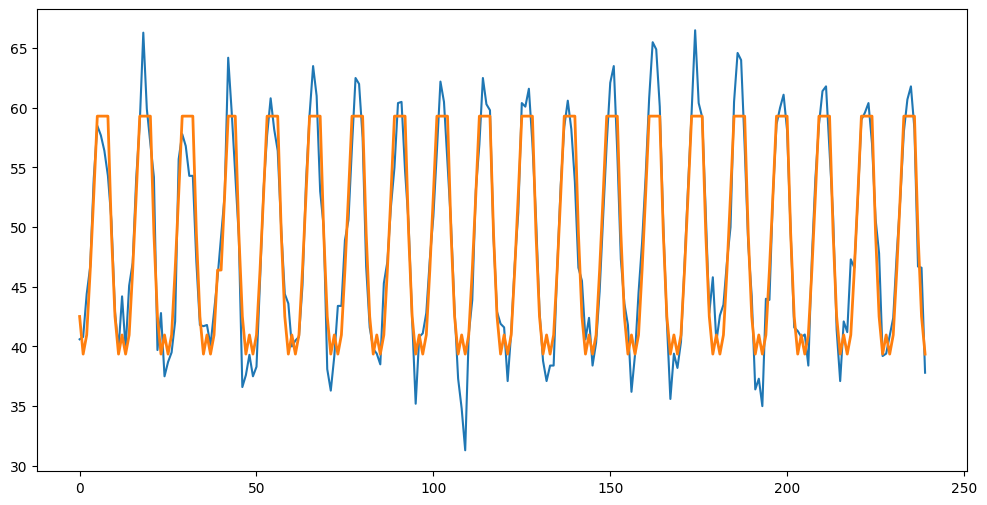

In [320]:
model = GaussianHMM(n_components=7,
                    covariance_type="diag",
                    n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
  means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=2)
plt.show()

# 6. Hаивный прогноз ряда

In [321]:
model.means_, len(model.means_)

(array([[52.70339817],
        [42.51439819],
        [49.51382701],
        [40.96604689],
        [39.36138799],
        [59.30462416],
        [46.40468469]]),
 7)

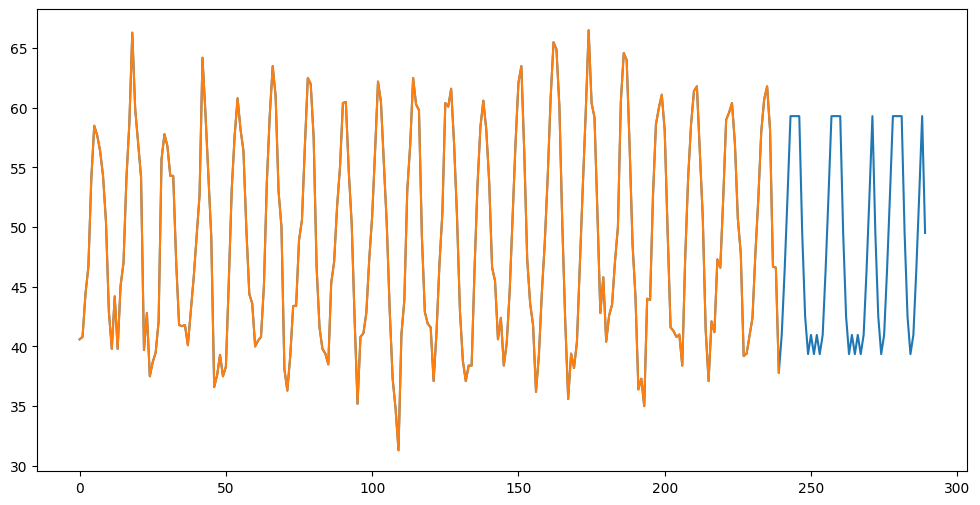

In [322]:
index = labels[-1]
n = 50
val = []

for i in range(n):
  index = np.random.choice(list(range(len(model.means_))), p=model.transmat_[index])
  val.append(model.means_[index])

new_values = np.concatenate((values, np.array(val)))

plt.figure(figsize=(12, 6))
plt.plot(new_values)
plt.plot(values)
plt.show()